In [42]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import itertools
from sklearn.metrics import classification_report

In [43]:
df = pd.read_csv('Training_Dataset/2500_training_data_2.csv')
X,y = df['tweet'],df['label']
print X.shape, y.shape

(2513,) (2513,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 45)
# print X_train.shape
# print X_train

# Feature Extraction (TF-IDF) unigrams and bigrams

In [45]:
#   - Filters out terms that occur in only one document (min_df=2).
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2),min_df=2)
X = vectorizer.fit_transform(X_train) 
train_tfidf_feature = X.toarray()
print train_tfidf_feature
print train_tfidf_feature.shape

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(1759, 3110)


# Feature Extraction (LSA)
Latent Semantic Analysis is a technique that analyzes relationship between a set of documents and of the terms. This method will extract contextual-usage meaning of words by statistical computations applied to a large corpus of text. 

Input: X[m][n] -> a matrix where m is the number of documents and n is the number of terms. 

The matrix X will be decomposed into three matrices called the U, S, and T. In doing the decomposition, a value of <i>k</i> will have to be picked since it will represent the number of concepts kept. 

<center>$X\approx USV^{T} $</center>

U[m][k] where the rows are the documents and the columns will be the mathematical concepts.

S[k][k] is a diagonal matrix where elements will be the amount of variation captured from each concept. 

V[m][k] transpose where the rows will be terms and the columns will be concepts.

In [46]:
lsa = TruncatedSVD(n_components = 500, n_iter=500)
train_lsa_feature = lsa.fit_transform(X)
print train_lsa_feature
print train_lsa_feature.shape


[[  2.01e-01  -4.01e-02  -5.45e-02 ...,   1.97e-02   1.76e-02  -2.60e-02]
 [  1.33e-01  -2.39e-02  -4.34e-02 ...,  -2.03e-02   5.44e-02   3.86e-02]
 [  1.52e-01  -5.27e-02   1.83e-01 ...,   3.35e-02  -2.60e-02   1.00e-02]
 ..., 
 [  6.79e-02  -4.40e-03  -1.75e-02 ...,  -1.04e-02  -1.80e-03   2.26e-03]
 [  1.09e-01  -1.52e-02   7.86e-03 ...,   1.52e-02   6.88e-03   6.52e-03]
 [  2.08e-01   9.21e-01   1.62e-01 ...,  -4.34e-03   3.75e-04  -2.49e-03]]
(1759, 500)


In [47]:
# print train_lsa_feature[0]
# print train_lsa_feature[1].shape

In [48]:
# #### To view list of related concepts
# terms = vectorizer.get_feature_names()
# for i, comp in enumerate(train_lsa_feature):
#     termsInComp = zip (terms, comp)
#     sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse = True) [:10]
#     print "Concept %d:" % i
#     for term in sortedTerms:
#         print term[0]
#     print " "

# SVM Classifier

In [49]:
clf1 = SGDClassifier(loss="hinge",
                    penalty="l2", shuffle=True,)
clf1.partial_fit(train_tfidf_feature,y_train,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [50]:
clf2 = SGDClassifier(loss="hinge",
                    penalty="l2", shuffle=True,)
clf2.partial_fit(train_lsa_feature,y_train,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

# Concatenating features

In [51]:
train_final_representation = np.concatenate((train_tfidf_feature,train_lsa_feature),axis=1)

In [52]:
class_weights = compute_class_weight('balanced', [0, 1], y)
class_weight_dictionary = {1:class_weights[0], 1:class_weights[1]}
clf3 = SGDClassifier(class_weight=class_weight_dictionary,loss="hinge",
                    penalty="l2", shuffle=True,)
# clf3 = SGDClassifier(class_weight=class_weight_dictionary)
clf3.partial_fit(train_final_representation,y_train,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False,
       class_weight={1: 1.3945615982241952}, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

# Testing Classifier

In [53]:
X2 = vectorizer.transform(X_test)
test_tfidf_feature = X2.toarray()
test_lsa_feature = lsa.transform(X2)

# TFIDF ONLY

In [54]:
prediction1 = clf1.predict(test_tfidf_feature)
# class_names = ['Non Flaming', 'Flaming'] = ['Positive', 'Negative']
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, prediction1)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# # plt.show()

# LSA ONLY

In [55]:
prediction2 = clf2.predict(test_lsa_feature)
# class_names = ['Non Flaming', 'Flaming']
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, prediction2)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

# CONCATENATED

In [56]:
test_final_representation = np.concatenate((test_tfidf_feature,test_lsa_feature),axis=1)
accuracy3 = clf3.score(test_final_representation,y_test) *100
prediction3 = clf3.predict(test_final_representation)
print "Accuracy: ",accuracy3
# print "Prediction: ",prediction3

Accuracy:  72.4137931034


In [57]:
print test_final_representation

[[ 0.    0.    0.   ..., -0.02 -0.03  0.02]
 [ 0.    0.    0.   ..., -0.01  0.01  0.01]
 [ 0.    0.    0.   ..., -0.03 -0.01  0.02]
 ..., 
 [ 0.    0.    0.   ...,  0.01  0.    0.03]
 [ 0.    0.    0.   ..., -0.01  0.02  0.02]
 [ 0.    0.    0.   ...,  0.02 -0.01  0.02]]


In [58]:
cf3 = confusion_matrix(y_test,prediction3)
print "CONCATENATED: "
print cf3


CONCATENATED: 
[[414  72]
 [136 132]]


Confusion matrix, without normalization
[[414  72]
 [136 132]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.51  0.49]]


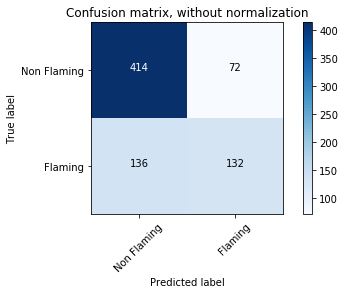

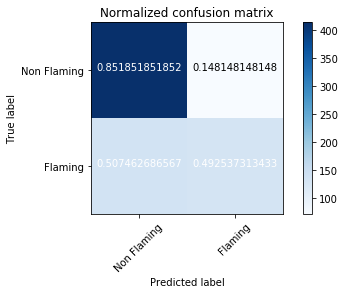

In [59]:
class_names = ['Non Flaming', 'Flaming']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [60]:
print "Classification Report: "
print "Concatenated: ",(classification_report(y_test, prediction3))
print "Accuracy: ", clf3.score(test_final_representation,y_test) *100
print "--------------------------------------------------------------------"
print "\n\nLSA: ",(classification_report(y_test, prediction2))
print "Accuracy: ", clf2.score(test_lsa_feature,y_test) *100
print "--------------------------------------------------------------------"
print "\n\nTFIDF: ",(classification_report(y_test, prediction1))
print "Accuracy: ", clf1.score(test_tfidf_feature,y_test) *100

Classification Report: 
Concatenated:               precision    recall  f1-score   support

          0       0.75      0.85      0.80       486
          1       0.65      0.49      0.56       268

avg / total       0.72      0.72      0.71       754

Accuracy:  72.4137931034
--------------------------------------------------------------------


LSA:               precision    recall  f1-score   support

          0       0.76      0.85      0.80       486
          1       0.66      0.51      0.58       268

avg / total       0.72      0.73      0.72       754

Accuracy:  73.2095490716
--------------------------------------------------------------------


TFIDF:               precision    recall  f1-score   support

          0       0.79      0.82      0.81       486
          1       0.65      0.62      0.63       268

avg / total       0.74      0.75      0.74       754

Accuracy:  74.6684350133


In [61]:
# save to pickle
import pickle

with open('Models/classifier.pkl', 'wb') as f:
    pickle.dump(clf3, f)
    
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
    
with open('Models/lsa.pkl', 'wb') as f:
    pickle.dump(lsa, f)
